In [1]:
import pandas as pd

# Replace 'your_file_path.xlsx' with the actual path to your Excel file.
file_path = r"C:\Users\karan\OneDrive\Desktop\GitHub Projects\UFC_Comments_Dataset.xlsx"

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Display the first 5 rows of the DataFrame to verify the import
print(df.head())

                                             comment
0  All tuporia knockout puches are comes from met...
1  13:44 at this moment, you can see Ilia kissing...
2                         Out non european; ONLY NE.
3  Ilia has very high fight iq and he makes his o...
4  Max still did better boxing-wise IMO. Stats do...


In [2]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# --- One-time setup for NLTK ---
# You only need to run these download commands once.
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
df.to_excel("UFC_Dataset2.xlsx", index=False)
# ---------------------------------

# Assuming 'df' is your DataFrame that is already loaded.
# If not, load it first:
# df = pd.read_excel('your_file_path.xlsx')

# 1. Remove missing rows from the 'Review' column
# A new DataFrame is created, but we will keep adding columns to it.
df_cleaned = df.dropna(subset=['comment']).copy()

# 2. Make the 'Review' text lowercase
df_cleaned['comment_lowercase'] = df_cleaned['comment'].str.lower()

# 3. Remove special characters
# This will keep only letters and numbers.
df_cleaned['comment_no_special_chars'] = df_cleaned['comment_lowercase'].str.replace(r'[^A-Za-z0-9\s]+', '', regex=True)

# 4. Tokenize the text
# The .apply() method is used to apply the tokenization function to each review.
df_cleaned['comment_tokenized'] = df_cleaned['comment_no_special_chars'].apply(word_tokenize)

# 5. Remove stopwords
stop_words = set(stopwords.words('english'))
df_cleaned['comment_no_stopwords'] = df_cleaned['comment_tokenized'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Display the first 5 rows with the new columns
print(df_cleaned[['comment', 'comment_lowercase', 'comment_no_special_chars', 'comment_tokenized', 'comment_no_stopwords']].head())

                                             comment  \
0  All tuporia knockout puches are comes from met...   
1  13:44 at this moment, you can see Ilia kissing...   
2                         Out non european; ONLY NE.   
3  Ilia has very high fight iq and he makes his o...   
4  Max still did better boxing-wise IMO. Stats do...   

                                   comment_lowercase  \
0  all tuporia knockout puches are comes from met...   
1  13:44 at this moment, you can see ilia kissing...   
2                         out non european; only ne.   
3  ilia has very high fight iq and he makes his o...   
4  max still did better boxing-wise imo. stats do...   

                            comment_no_special_chars  \
0  all tuporia knockout puches are comes from met...   
1  1344 at this moment you can see ilia kissing t...   
2                           out non european only ne   
3  ilia has very high fight iq and he makes his o...   
4  max still did better boxingwise imo stats d

In [3]:
!pip install textblob

In [4]:
import pandas as pd
from textblob import TextBlob

# Assuming 'df_cleaned' is your DataFrame from the previous step.

# 1. Join the tokens back into a single string for TextBlob analysis
# TextBlob works on strings, and our 'review_no_stopwords' column is a list of words.
df_cleaned['final_processed_text'] = df_cleaned['comment_no_stopwords'].apply(lambda tokens: ' '.join(tokens))

# 2. Calculate Sentiment Score (Polarity)
# We apply TextBlob to each processed review and get the polarity score.
df_cleaned['sentiment_score'] = df_cleaned['final_processed_text'].apply(lambda text: TextBlob(text).sentiment.polarity)

# 3. Create Sentiment Category based on the score
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_cleaned['sentiment_category'] = df_cleaned['sentiment_score'].apply(categorize_sentiment)

# 4. Prepare the final DataFrame for export
# This will include the original columns plus the new sentiment columns.
# We will drop the intermediate processing columns for a cleaner output file.
output_df = df_cleaned.drop(columns=[
    'comment_lowercase',
    'comment_no_special_chars',
    'comment_tokenized',
    'comment_no_stopwords',
    'final_processed_text'
])

# 5. Export the DataFrame to a new Excel file
output_file_path = 'comment_with_sentiment.xlsx'
output_df.to_excel(output_file_path, index=False)

print(f"Sentiment analysis complete. The results have been saved to '{output_file_path}'")
print("\nHere's a preview of the final data:")
print(output_df[['comment', 'sentiment_score', 'sentiment_category']].head())

Sentiment analysis complete. The results have been saved to 'comment_with_sentiment.xlsx'

Here's a preview of the final data:
                                             comment  sentiment_score  \
0  All tuporia knockout puches are comes from met...         0.000000   
1  13:44 at this moment, you can see Ilia kissing...         0.184091   
2                         Out non european; ONLY NE.         0.000000   
3  Ilia has very high fight iq and he makes his o...         0.160000   
4  Max still did better boxing-wise IMO. Stats do...         0.350000   

  sentiment_category  
0            Neutral  
1           Positive  
2            Neutral  
3           Positive  
4           Positive  


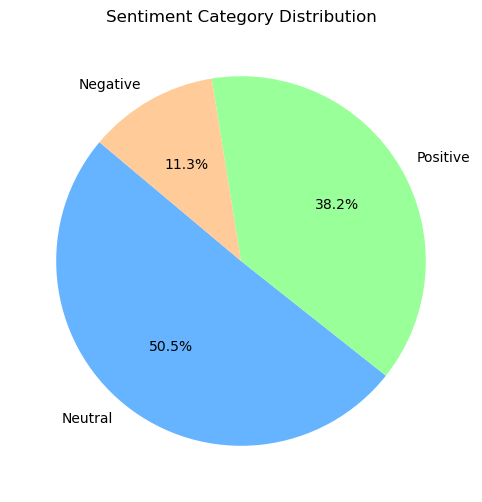

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the Excel file
file_path = 'comment_with_sentiment.xlsx'
df = pd.read_excel(file_path)

# Calculate the distribution of sentiment categories
sentiment_counts = df['sentiment_category'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Sentiment Category Distribution')
plt.ylabel('') # This is to remove the default 'sentiment_category' ylabel
plt.show()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# 1. Vectorize the text data using TF-IDF
# We convert the text into a numerical format. We'll ignore words that appear in
# more than 95% of documents (max_df=0.95) or in fewer than 2 documents (min_df=2).
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(df_cleaned['final_processed_text'])

# 2. Apply Non-Negative Matrix Factorization (NMF)
# We will fit the NMF model to our vectorized data to find 5 topics.
num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf)

# 3. Display the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        # We print the top N words that are most representative of the topic
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print()

feature_names = vectorizer.get_feature_names_out()
num_top_words = 10

print("Top 10 words for each of the 5 topics:")
display_topics(nmf_model, feature_names, num_top_words)

# 4. Assign the dominant topic to each comment
# This helps in analyzing which topic each comment belongs to.
topic_results = nmf_model.transform(tfidf)
df_cleaned['topic'] = topic_results.argmax(axis=1)

# Display a preview of the comments with their assigned topics
print("\nPreview of comments with their assigned topics:")
print(df_cleaned[['comment', 'topic']].head())

Top 10 words for each of the 5 topics:
Topic #1:
max ilia got like rematch power think round 155 winning
Topic #2:
fight good 155 man dustin think id illia incredible great
Topic #3:
topuria vs islam bro te love want easy crazy holloway
Topic #4:
que el la en es lo si le holloway por
Topic #5:
best boxer ufc holloway im ilia better baby actually mf


Preview of comments with their assigned topics:
                                             comment  topic
0  All tuporia knockout puches are comes from met...      4
1  13:44 at this moment, you can see Ilia kissing...      0
2                         Out non european; ONLY NE.      4
3  Ilia has very high fight iq and he makes his o...      1
4  Max still did better boxing-wise IMO. Stats do...      0


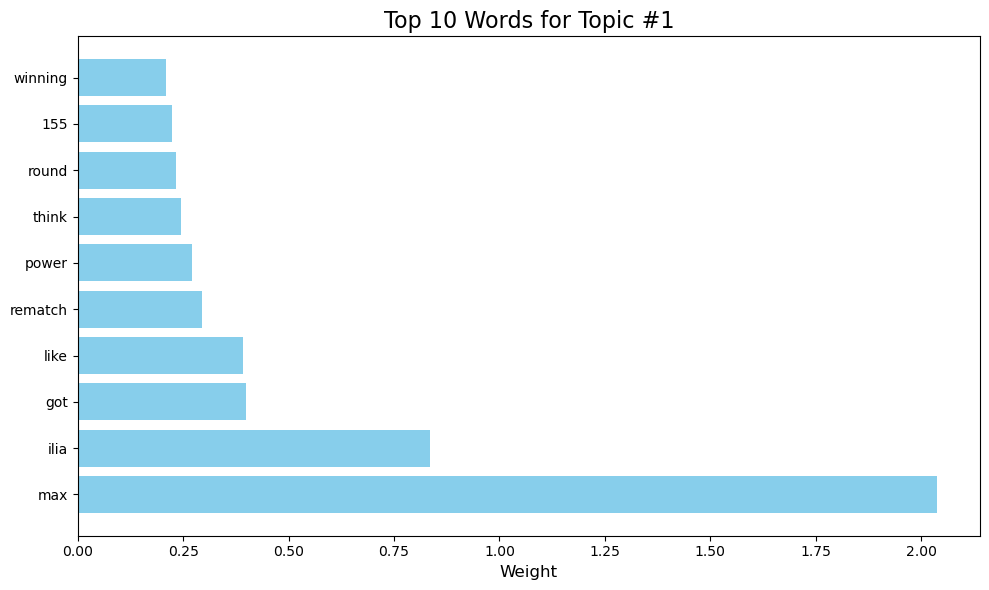

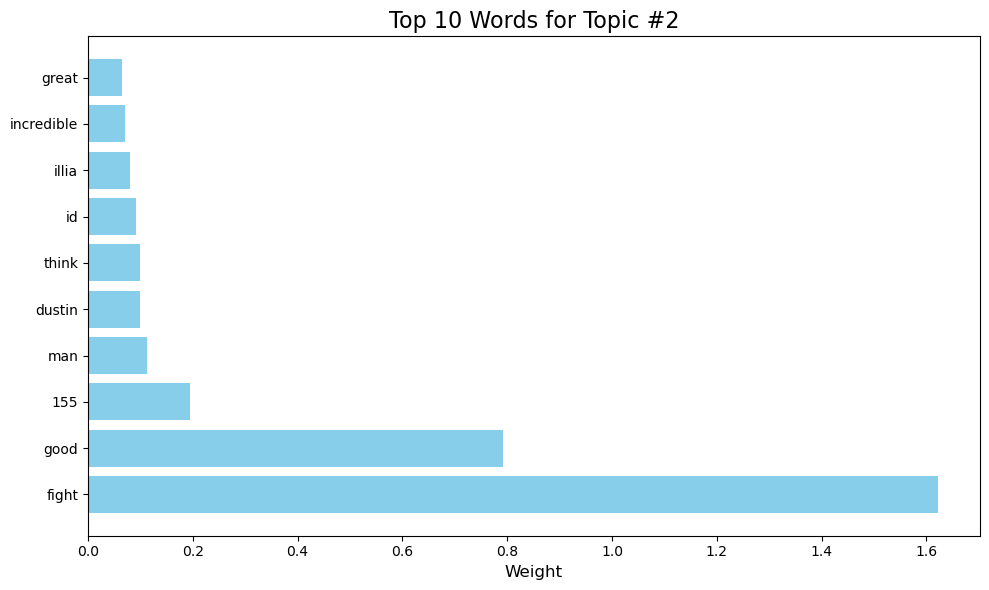

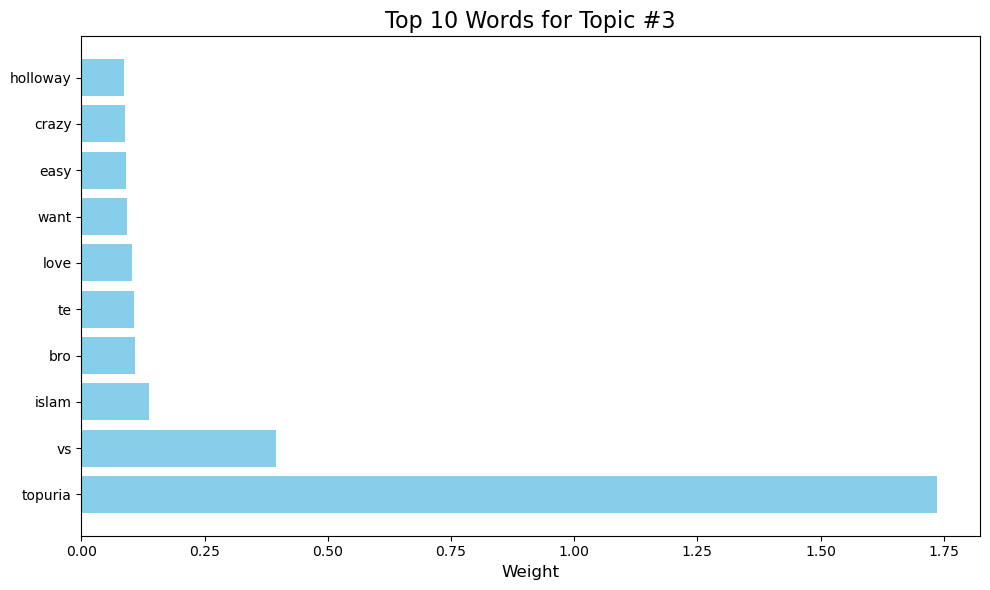

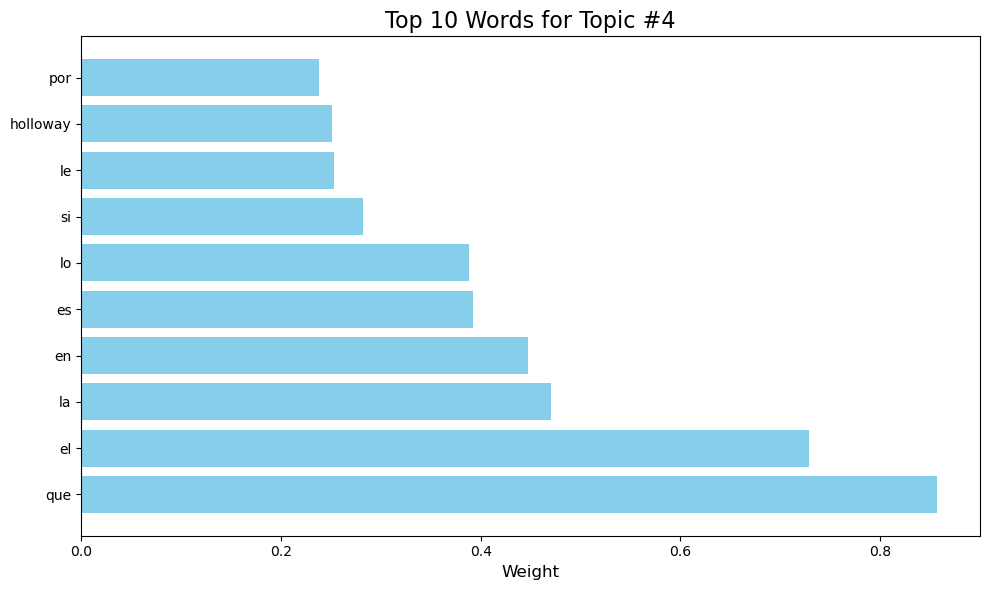

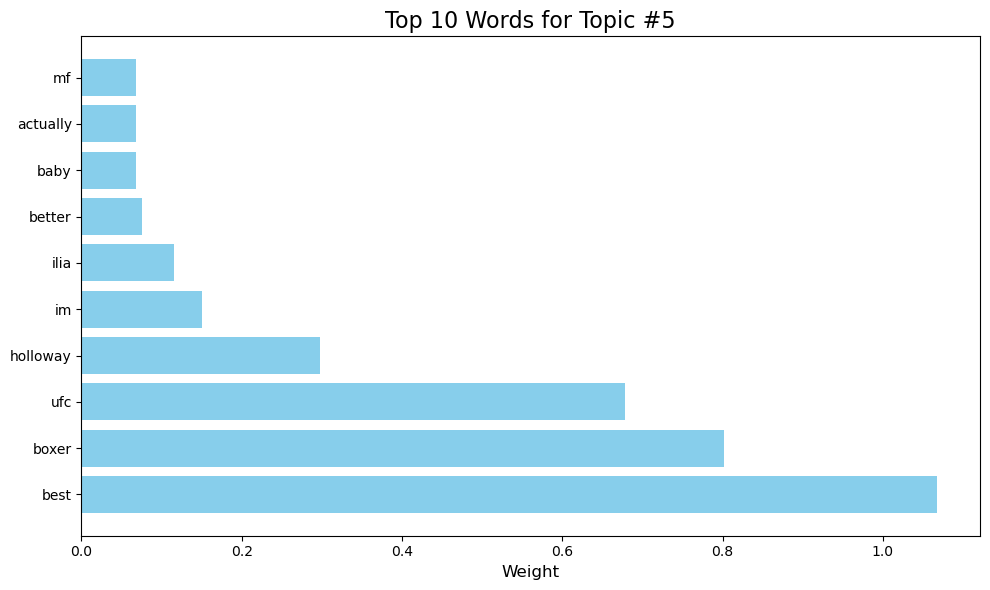

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# This code assumes 'nmf_model' and 'vectorizer' from the previous step are available.

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()
num_top_words = 10

# Loop through each topic and create a bar chart for it
for topic_idx, topic in enumerate(nmf_model.components_):
    # Get the indices of the top N words for this topic
    top_features_ind = topic.argsort()[-num_top_words:]
    
    # Get the actual words and their weights
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_features, weights, color='skyblue')
    plt.title(f'Top 10 Words for Topic #{topic_idx + 1}', fontsize=16)
    plt.xlabel('Weight', fontsize=12)
    plt.gca().invert_yaxis() # To display the most important word at the top
    plt.tight_layout()
    plt.show()

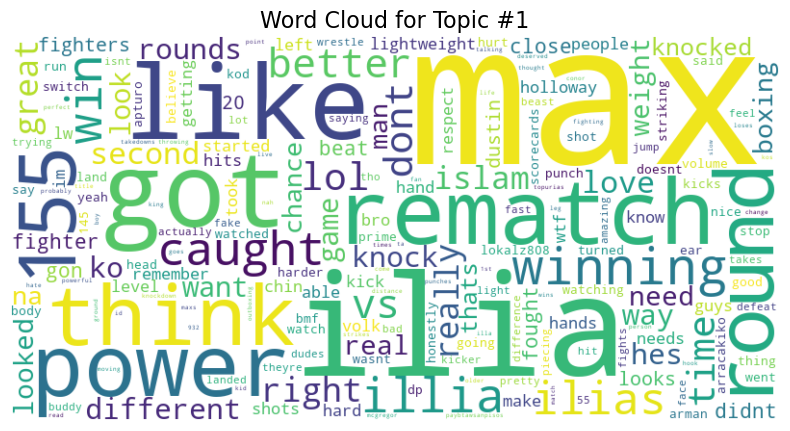

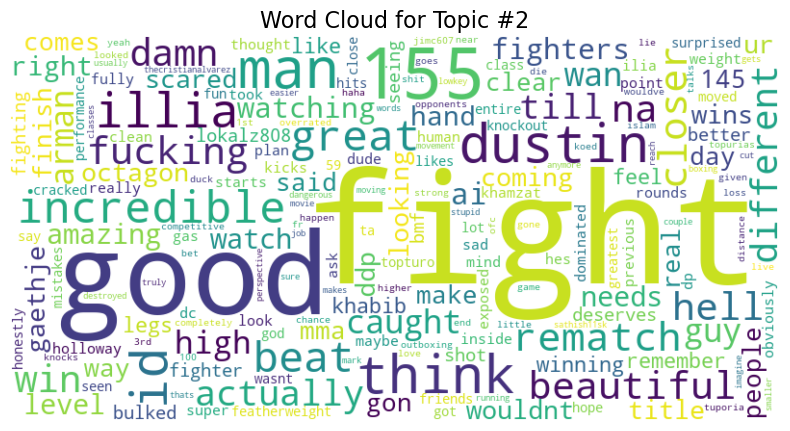

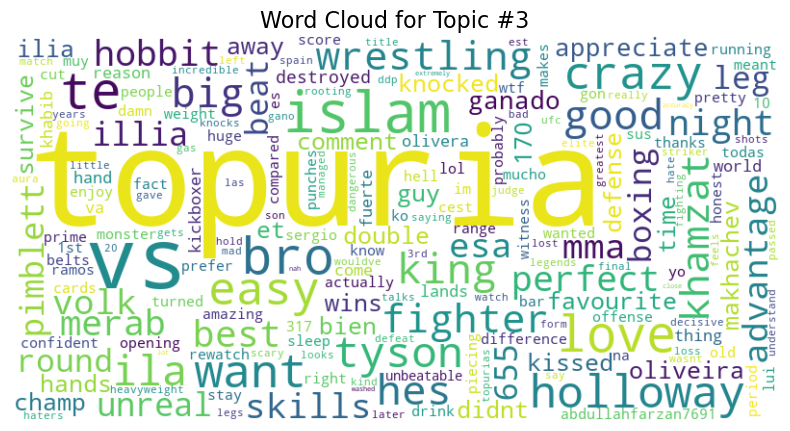

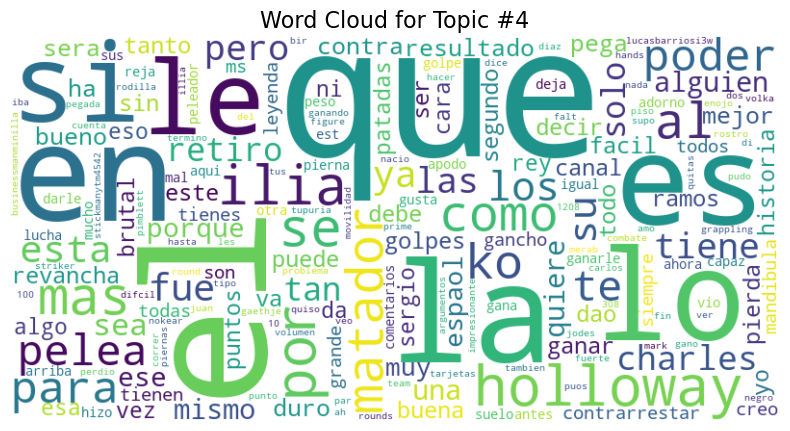

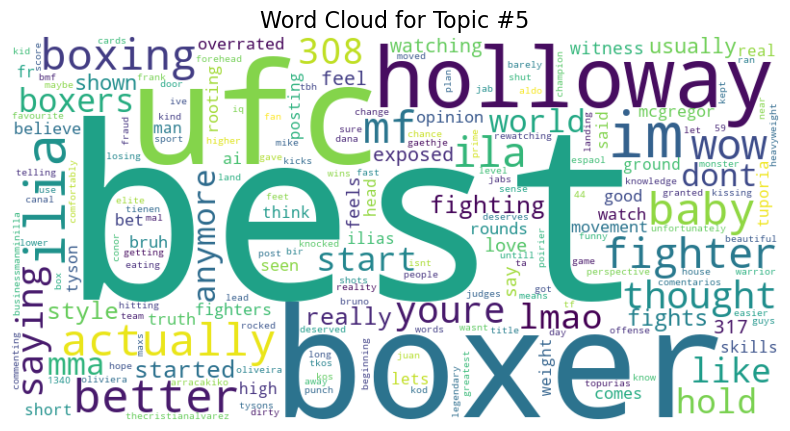

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# This code assumes 'nmf_model' and 'vectorizer' from the previous steps are available.

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Loop through each topic and generate a word cloud
for topic_idx, topic in enumerate(nmf_model.components_):
    # Create a dictionary of words and their weights for the current topic
    topic_words = {feature_names[i]: topic[i] for i in topic.argsort()}
    
    # Create the WordCloud object
    # The generate_from_frequencies method uses the weights from NMF directly
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    
    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Topic #{topic_idx + 1}', fontsize=16)
    plt.axis('off')
    plt.show()